<a href="https://colab.research.google.com/github/SiriusBits/ml-engineering-lab/blob/main/notebooks/regression-algs/Customer_churn_mwyss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve

# Read Data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/My Drive/ML-09: Regression Algorithms/Assignment & MCQ/Assignment  Datasets"
data = pd.read_csv(f"{data_path}/Telco-Customer-Churn.csv")

https://www.kaggle.com/datasets/blastchar/telco-customer-churn

Context
"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]



Content
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.



The data set includes information about:

Customers who left within the last month – the column is called Churn
Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
Demographic info about customers – gender, age range, and if they have partners and dependents

In [ ]:
# Remove data columns
data.drop(columns=['customerID'], inplace=True)

In [ ]:
data[:3]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


# EDA


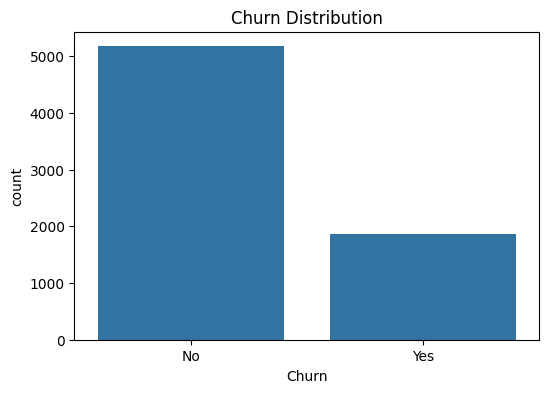

In [ ]:
# Check the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=data)
plt.title("Churn Distribution")
plt.show()

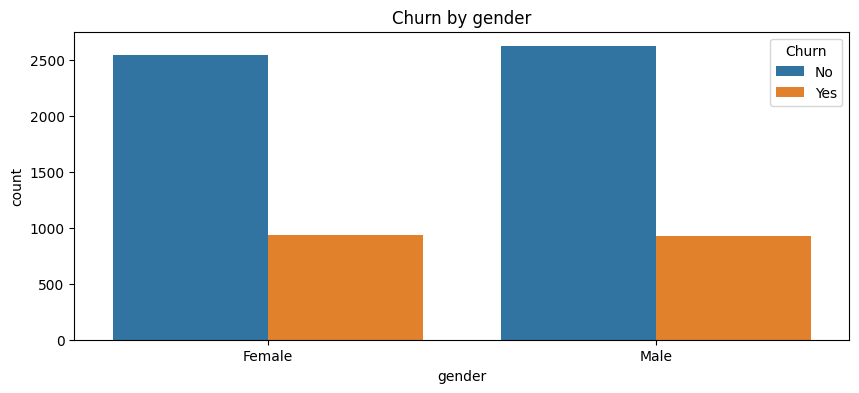

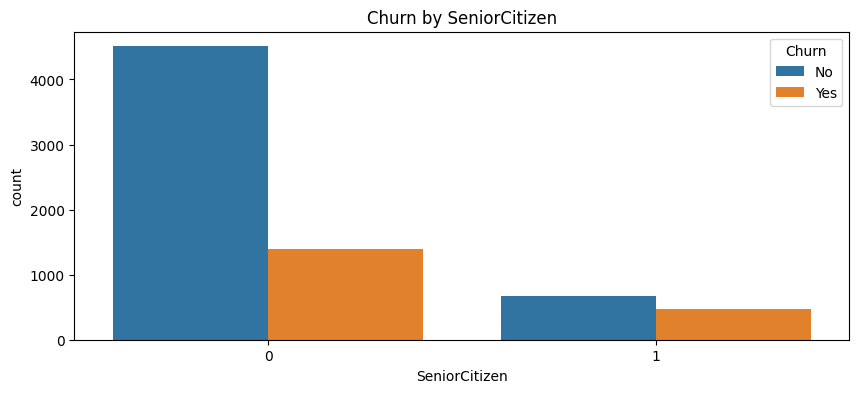

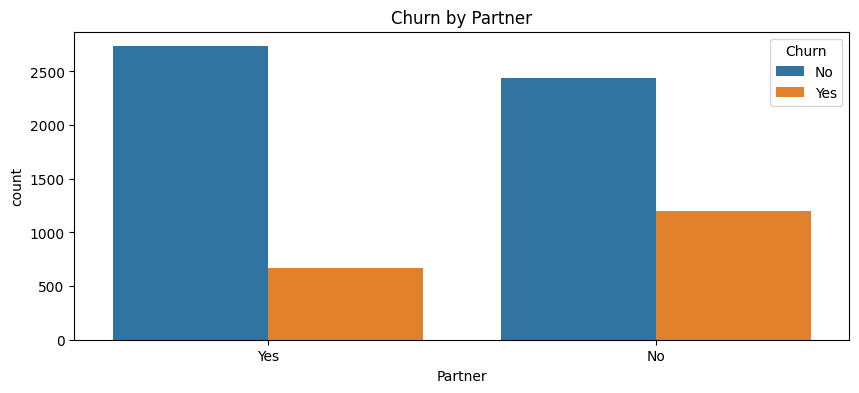

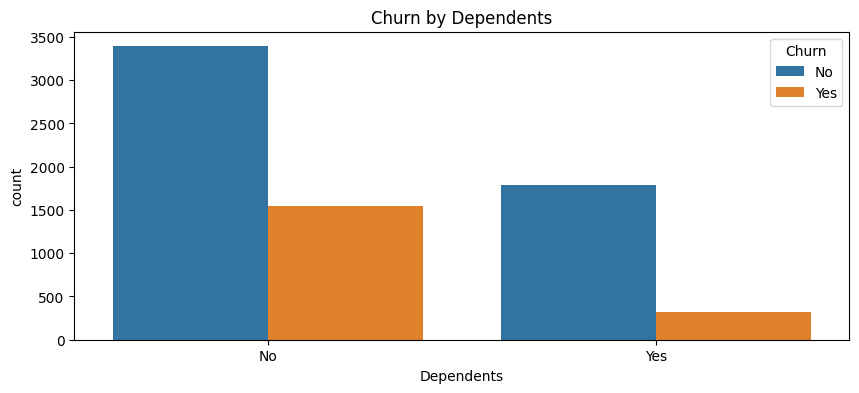

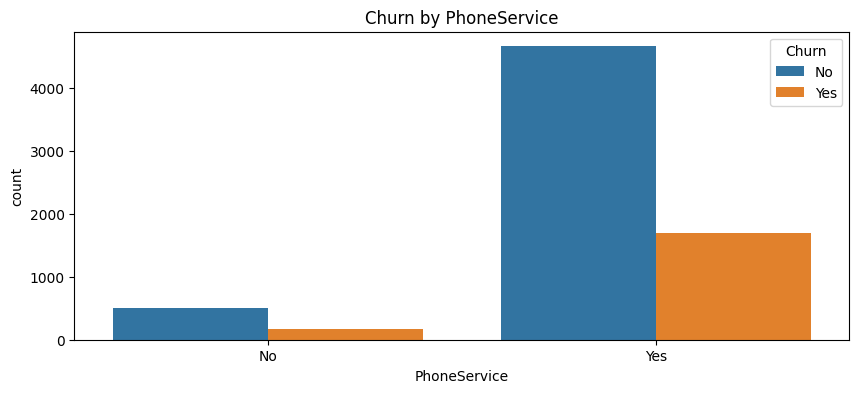

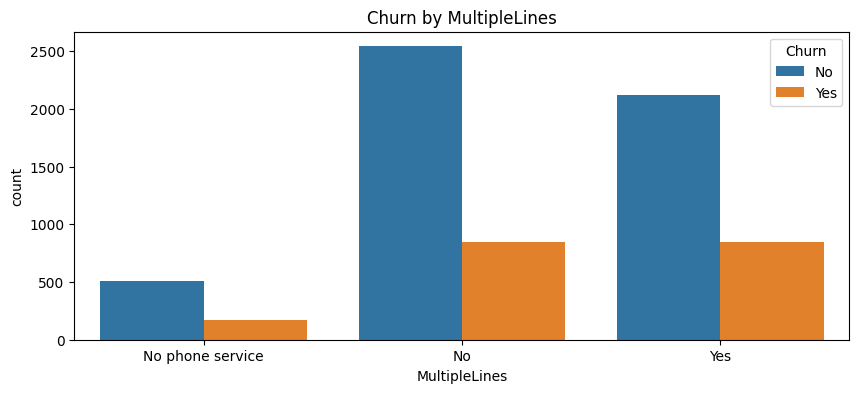

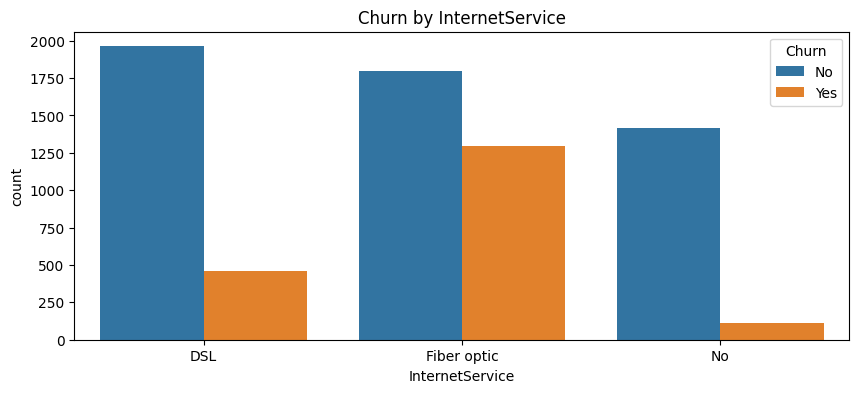

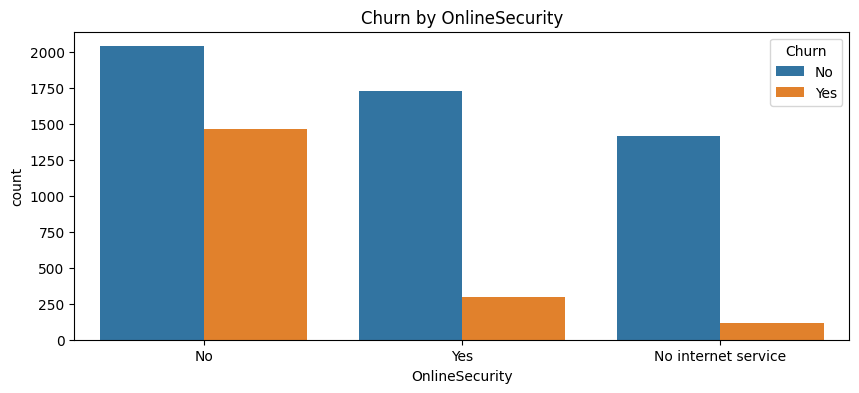

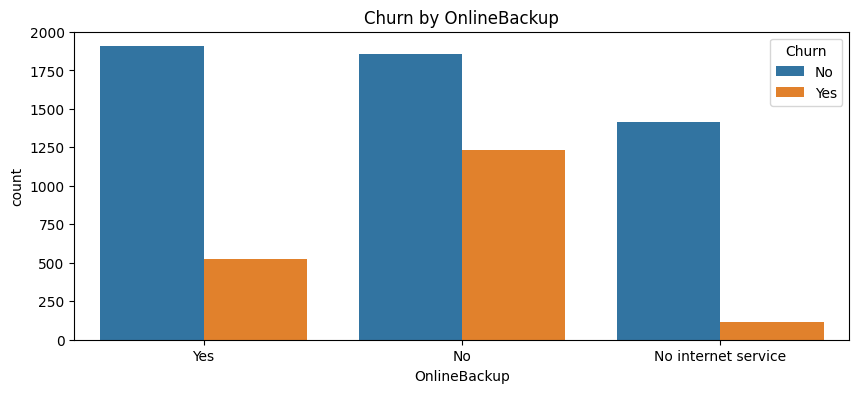

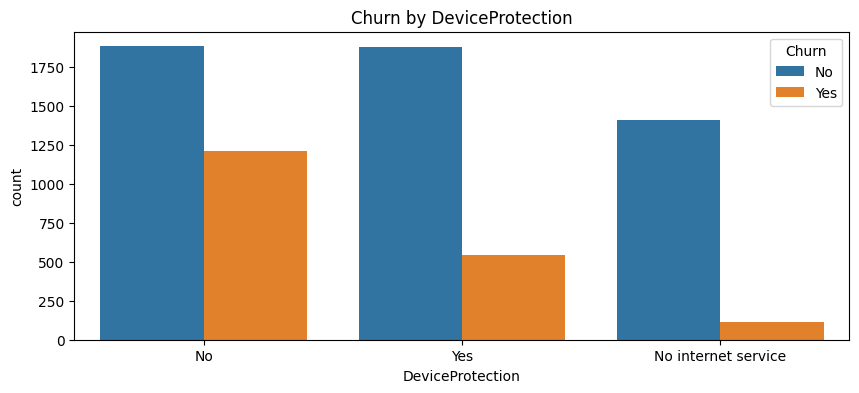

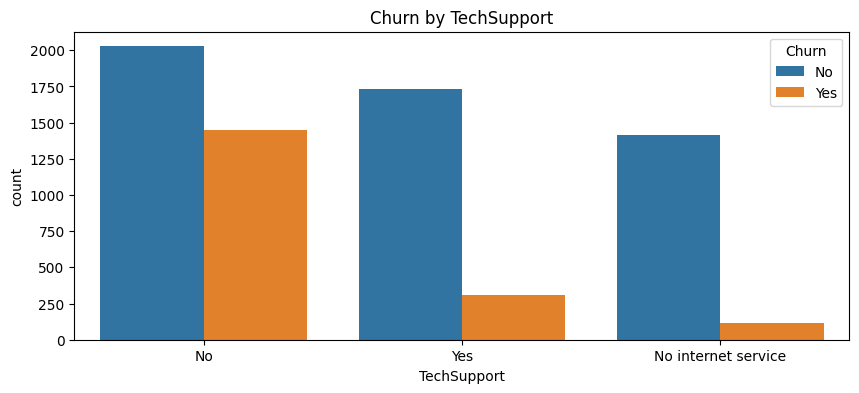

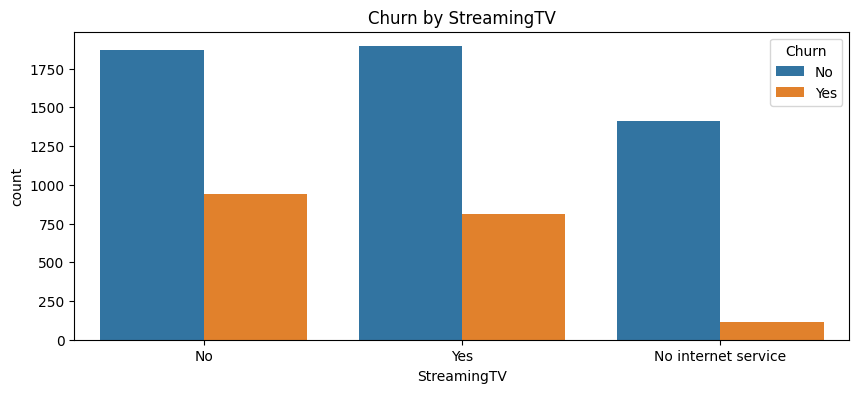

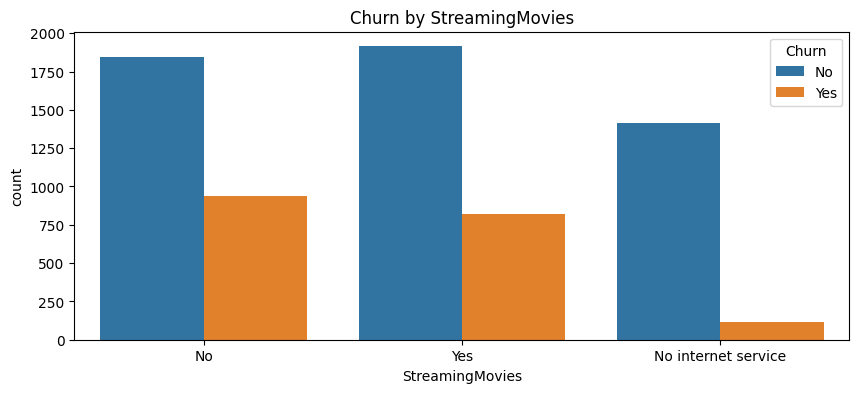

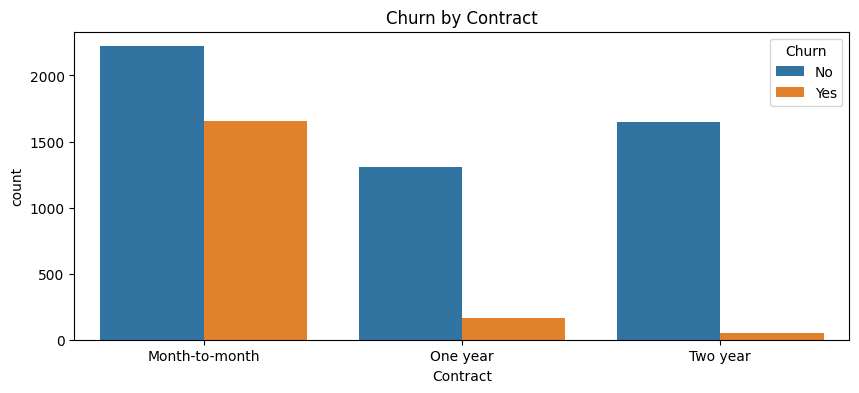

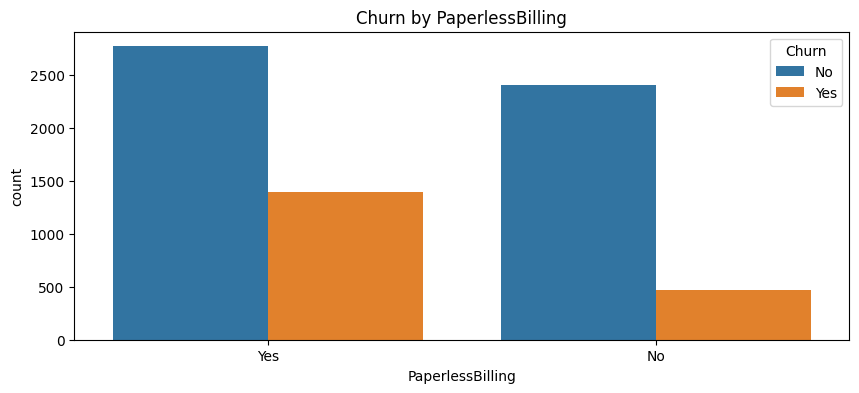

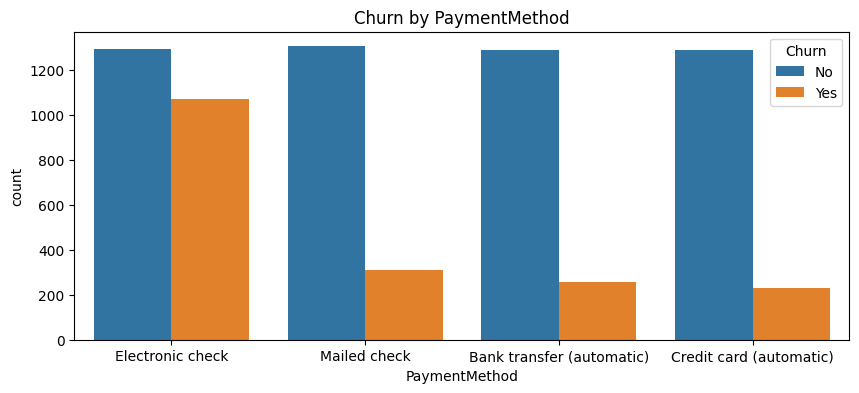

In [ ]:
# Analyze churn rate by categorical features
categorical_columns = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

for column in categorical_columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=column, hue='Churn', data=data)
    plt.title(f"Churn by {column}")
    plt.show()

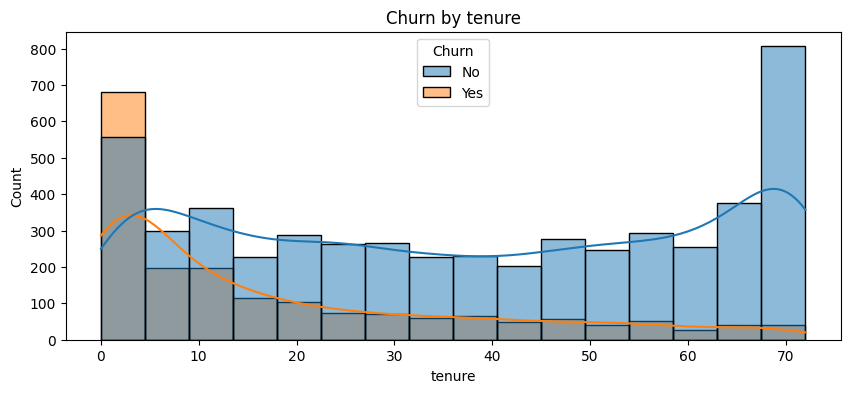

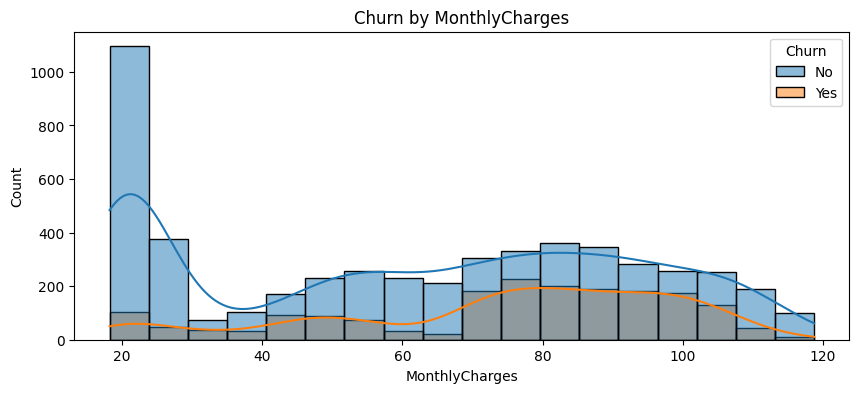

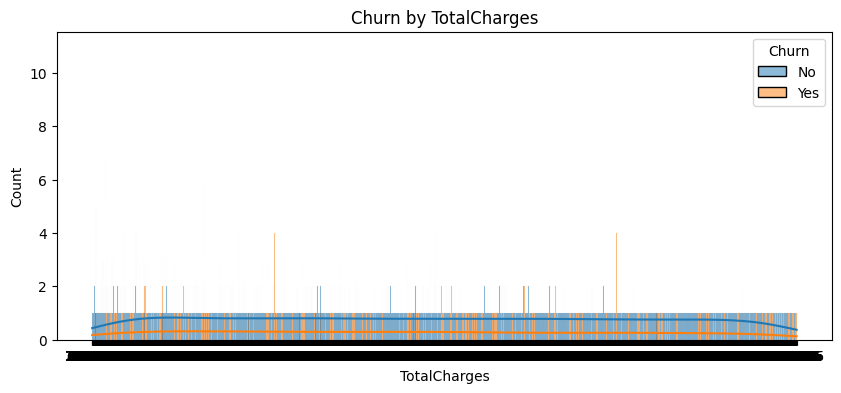

In [ ]:
# Analyze churn rate by numeric features
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

for column in numeric_columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(x=column, hue='Churn', data=data, kde=True) #kernel density estimation
    plt.title(f"Churn by {column}")
    plt.show()

<ipython-input-11-5972175f247f>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data[numeric_columns+["target"]].corr(), annot=True, cmap="coolwarm")


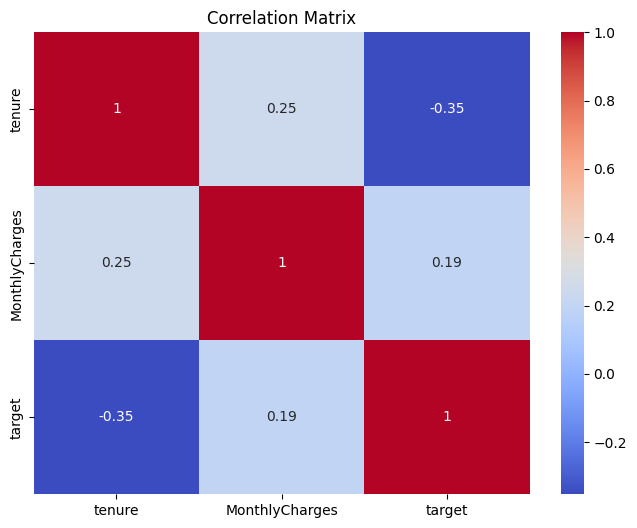

In [ ]:
# Analyze the correlation between numeric features
plt.figure(figsize=(8, 6))
sns.heatmap(data[numeric_columns+["Churn"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

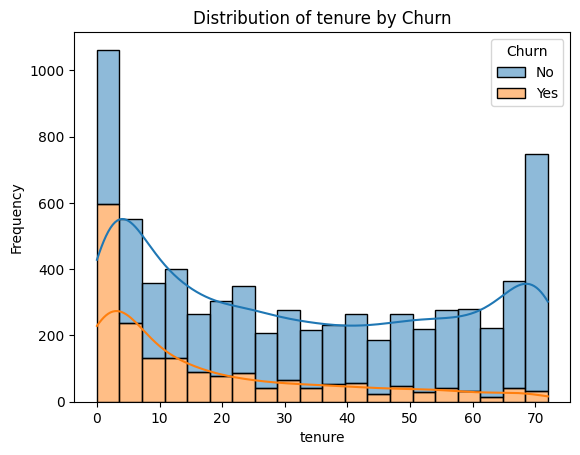

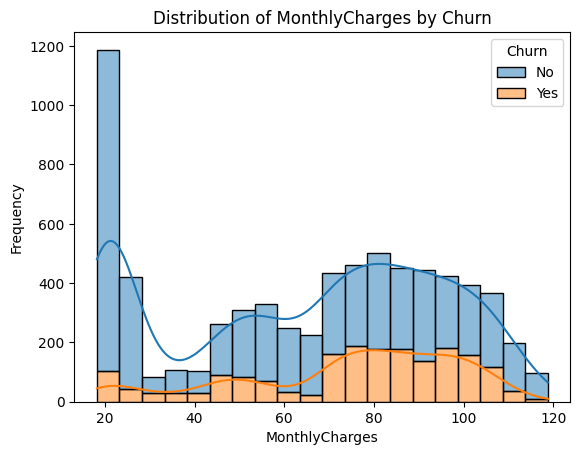

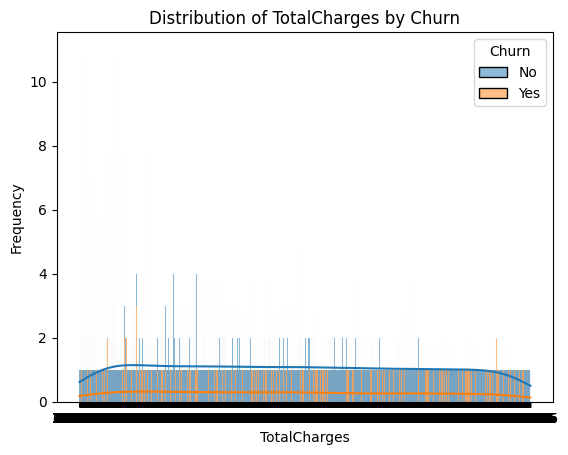

In [ ]:
for i, col1 in enumerate(numeric_columns):
    plt.figure()
    sns.histplot(data=data, x=col1, hue='Churn', kde=True, multiple='stack', bins=20, legend='auto')
    plt.xlabel(col1)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {col1} by Churn')
    plt.show()

# Feature Engineering

In [ ]:
# Convert TotalCharges to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

## Categorical Feature Handling

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


Multicollinearity refers to the situation where two or more predictor variables in a regression model are highly correlated. In the context of one-hot encoding, if you have a categorical variable with  n levels, you typically create n binary (0 or 1) variables to represent each level. However, you only need n−1 of these binary variables to represent all the information about the original categorical variable.

For example, if you have a categorical variable "Color" with three levels: Red, Green, and Blue, you can represent it with two binary variables: "IsGreen" and "IsBlue." If both "IsGreen" and "IsBlue" are 0, it implies that the color is "Red."

The "drop_first" parameter, when set to True, tells the one-hot encoding process to drop the first level of each categorical variable. This effectively creates n−1 binary variables instead of n, reducing the risk of multicollinearity.

In [ ]:
# One-hot encode categorical features
categorical_columns = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

In [ ]:
data.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,No,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0,34,56.95,1889.50,No,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,2,53.85,108.15,Yes,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,0,45,42.30,1840.75,No,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,2,70.70,151.65,Yes,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


In [ ]:
# Encode the 'Churn' column
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})
#data['Churn'] = np.where(data['Churn'] == 'Yes', 1, 0)

# Model Training

In [ ]:
from sklearn.model_selection import train_test_split

def split_data(df: pd.DataFrame, target: str, test_size: float):
    X = df.drop([target], axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = split_data(data, 'Churn', 0.2)

In [ ]:
X_train.dtypes

SeniorCitizen                              int64
tenure                                     int64
MonthlyCharges                           float64
TotalCharges                             float64
gender_Male                                uint8
Partner_Yes                                uint8
Dependents_Yes                             uint8
PhoneService_Yes                           uint8
MultipleLines_No phone service             uint8
MultipleLines_Yes                          uint8
InternetService_Fiber optic                uint8
InternetService_No                         uint8
OnlineSecurity_No internet service         uint8
OnlineSecurity_Yes                         uint8
OnlineBackup_No internet service           uint8
OnlineBackup_Yes                           uint8
DeviceProtection_No internet service       uint8
DeviceProtection_Yes                       uint8
TechSupport_No internet service            uint8
TechSupport_Yes                            uint8
StreamingTV_No inter

In [ ]:
X_train['TotalCharges'] = pd.to_numeric(X_train['TotalCharges'], errors='coerce')
X_test['TotalCharges'] = pd.to_numeric(X_test['TotalCharges'], errors='coerce')

In [ ]:
# We should actually impute the mean here
train_total_charges_mean = np.mean(X_train['TotalCharges'])
X_train['TotalCharges'].fillna(train_total_charges_mean, inplace=True)
X_test['TotalCharges'].fillna(train_total_charges_mean, inplace=True)

In [ ]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Build the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

In [ ]:
y_pred

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
# Calculate the accuracy, confusion matrix, and classification report
accuracy = accuracy_score(y_test, y_pred)
# Calculate precision, recall, F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Accuracy:  0.8211497515968772
Precision:  0.6873065015479877
Recall:  0.5951742627345844
F1-score:  0.6379310344827587


In [ ]:
# Class imbalance
lr_balanced = LogisticRegression(class_weight='balanced')
lr_balanced.fit(X_train, y_train)

# Make predictions
y_pred_b = lr_balanced.predict(X_test)

In [ ]:
# Calculate the accuracy, confusion matrix, and classification report
accuracy = accuracy_score(y_test, y_pred_b)
# Calculate precision, recall, F1-score
precision = precision_score(y_test, y_pred_b)
recall = recall_score(y_test, y_pred_b)
f1 = f1_score(y_test, y_pred_b)

# Print the results
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Accuracy:  0.7473385379701917
Precision:  0.5142378559463987
Recall:  0.8230563002680965
F1-score:  0.6329896907216496


In [ ]:
y_prob = log_reg.predict_proba(X_test)

In [ ]:
y_pred

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
y_prob

array([[0.31033487, 0.68966513],
       [0.93738226, 0.06261774],
       [0.99540758, 0.00459242],
       ...,
       [0.94886774, 0.05113226],
       [0.98667452, 0.01332548],
       [0.51205594, 0.48794406]])

In [ ]:
log_reg.coef_

array([[ 0.0584765 , -1.31473237, -0.63433161,  0.61326437, -0.02562791,
         0.02710379, -0.07449952, -0.03369567,  0.03369567,  0.16980513,
         0.62656216, -0.07596166, -0.07596166, -0.15762627, -0.07596166,
        -0.04332652, -0.07596166,  0.02934597, -0.07596166, -0.11996533,
        -0.07596166,  0.18182741, -0.07596166,  0.23224287, -0.26869045,
        -0.61841338,  0.16371312, -0.03513742,  0.15259704, -0.01175319]])

AUC:  0.8619704058712102


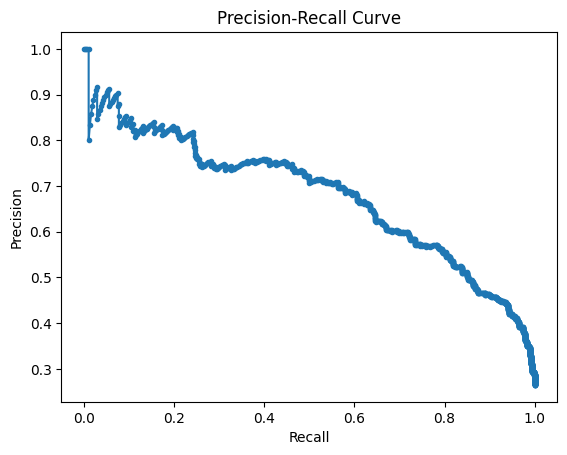

In [ ]:
# Calculate the probability of the target class (class 1)
y_prob = log_reg.predict_proba(X_test)[:, 1]

# AUC
auc = roc_auc_score(y_test, y_prob)
print("AUC: ", auc)

# Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Plot the Precision-Recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# HyperParameter Tuning

for parameter referes https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html




1. `'C'`: This parameter represents the inverse of regularization strength. Smaller values of `C` result in stronger regularization, which can help prevent overfitting by penalizing large coefficients in the model.

2. `'penalty'`: This parameter determines the type of regularization to be applied to the model. Regularization is used to prevent overfitting by penalizing large coefficients in the model. The `'l2'` penalty, also known as Ridge regularization, adds the squared magnitude of the coefficients to the loss function. In this case, you have specified only the `'l2'` penalty.

3. `'solver'`: This parameter specifies the optimization algorithm to be used for training the logistic regression model. Different solvers have different performance characteristics and may be more suitable for specific types of datasets or problems. In this case, you have specified five solvers:

   - `'newton-cg'`: Newton Conjugate Gradient, a second-order optimization method that approximates the Hessian matrix for efficient optimization. Suitable for large datasets and supports L2 regularization.
   - `'lbfgs'`: Limited-memory Broyden-Fletcher-Goldfarb-Shanno, a quasi-Newton method that also approximates the Hessian matrix. Suitable for small to moderately-sized datasets and supports L2 regularization. It is the default solver in scikit-learn.
   - `'liblinear'`: A linear solver that uses the coordinate gradient descent algorithm. Suitable for smaller datasets and supports both L1 and L2 regularization. However, it may have slower convergence for large datasets.
   - `'sag'`: Stochastic Average Gradient descent, an optimization algorithm that uses a random sample of the data at each iteration. Suitable for large datasets and supports L2 regularization.
   - `'saga'`: Stochastic Average Gradient descent with support for both L1 and L2 regularization. Suitable for large datasets and sparse data.

In [ ]:
# Custom parameter grid
param_grid = [
    {'penalty': ['l1'],
     'solver': ['liblinear', 'saga'],
     'C': [0.001, 0.01, 0.1, 1, 10],
     'max_iter': [1000, 5000],
     'class_weight': ['balanced']
    },
    {'penalty': ['l2'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'C': [ 1, 10, 20, 50],
     'max_iter': [1000, 5000],
     'class_weight': ['balanced']
    },
    {'penalty': ['elasticnet'],
     'solver': ['saga'],
     'C': [0.001, 0.01, 0.1, 1, 10, 50],
     'max_iter': [1000, 5000],
     'class_weight': ['balanced'],
     'l1_ratio': [0, 0.3, 0.5, 0.7, 1]
    }
]

# Build and tune the logistic regression model
log_reg = LogisticRegression()
# RandomSearchCV is more efficient but might miss the best hyperparameters
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Calculate the accuracy, confusion matrix, and classification report
accuracy = accuracy_score(y_test, y_pred_best)
# Calculate precision, recall, F1-score, and AUC
precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)

# Print the results
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Best Parameters:  {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best Accuracy:  0.8161761426978819
Accuracy:  0.7345635202271115
Precision:  0.49920255183413076
Recall:  0.839142091152815
F1-score:  0.626


Hyperpram tuning does not help
